In [1]:
from generator import UniformCNFGenerator
from architectures import BasicRNN
from architectures import BaselineRollout
import utils
import train
import eval
import run

import torch
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from PyMiniSolvers import minisolvers

import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter

## Experiment 1

1. Create random sat formula
2. Check the number of sat clauses with the following solvers (mean over 10 times):
* Random assignment
* RNN model
* RNN model with baseline 

In [2]:
def experiment(experiment_name):
    num_experiments = 10 #num of times each experiment is run

    #CNF Formula
    n = 20 #Num variables
    k = 3  #Clause size
    r_list = [2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6] #Radious
    
    #Network
    embedding_size = 32
    hidden_size = 128
    num_layers = 1
    cell = 'GRU'
    dropout = 0

    input_size = n  # Num of variables
    output_size = 2  # Two assignments: 0 or 1
    num_rollouts = 2  # For baseline. Greedy: -1, #Sampled: 1, 2, 3, ...n

    # Training
    lr = 0.001
    accumulation_steps = 2
    entropy_weight = 0.2
    num_episodes = 1000
    clip_val = 1  # None, 1, 2, 3, ...n
    clip_logits = None # None, 1, 2, 3, ...n

    #num_sat_history = {'random': [], 'rnn': [], 'rnn_sb': [], 'rnn_gb': []}

    global_step = 0
    for _, r in enumerate(r_list):

        print(f'r = {r} ...')

        log_dir='outputs/' + experiment_name + '/runs/n' + str(n) +'/'+str(r)
        writer = SummaryWriter(log_dir = log_dir)        

        # Create a sat generator
        sat_gen = UniformCNFGenerator(min_n = n,
                                      max_n = n,
                                      min_k = k,
                                      max_k = k,
                                      min_r = r,
                                      max_r = r)
        
        for _ in tqdm(range(num_experiments)):
            
            # Create a random sat formula
            n, r, m, formula = sat_gen.generate_formula()

            ##################################################################
            # Random Model                                                   #
            ##################################################################
            num_sat = run.random_solver(n, formula)
            writer.add_scalar('random', num_sat, global_step, new_style=True)

            ##################################################################
            # MiniSat Solver                                                 #
            ##################################################################
            S = minisolvers.MinisatSolver()
            for i in range(n):
                S.new_var()
            for clause in formula:
                S.add_clause(clause)
            if S.solve():
                writer.add_scalar('minisat', m, global_step, new_style=True)
            else:
                writer.add_scalar('minisat', 0, global_step, new_style=True)
            
            ##################################################################
            # RNN Model                                                      #
            ##################################################################
            policy_network = BasicRNN(cell, input_size, embedding_size, hidden_size,
                                output_size, num_layers, dropout)
            baseline = None
            num_sat = run.learning_solver(n, formula, policy_network, baseline, lr,
                                          accumulation_steps, num_episodes, entropy_weight,
                                          clip_logits, clip_val)
            writer.add_scalar('rnn', num_sat, global_step, new_style=True)

            ##################################################################
            # RNN with sampled baseline                                      #
            ##################################################################
            policy_network = BasicRNN(cell, input_size, embedding_size, hidden_size,
                                output_size, num_layers, dropout)
            baseline = BaselineRollout(num_rollouts)
            num_sat = run.learning_solver(n, formula, policy_network, baseline, lr,
                                          accumulation_steps, num_episodes, entropy_weight,
                                          clip_logits, clip_val)
            writer.add_scalar('rnn_sb', num_sat, global_step, new_style=True)

            ##################################################################
            # RNN with greedy baseline                                       #
            ##################################################################
            policy_network = BasicRNN(cell, input_size, embedding_size, hidden_size,
                                output_size, num_layers, dropout)
            baseline = BaselineRollout(-1)
            num_sat = run.learning_solver(n, formula, policy_network, baseline, lr,
                                          accumulation_steps, num_episodes, entropy_weight,
                                          clip_logits, clip_val)
            writer.add_scalar('rnn_gb', num_sat, global_step, new_style=True)

            global_step +=1
    
        writer.close()

In [3]:
experiment_name = "exp1"
experiment(experiment_name)

  0%|          | 0/10 [00:00<?, ?it/s]

r = 2.8 ...


 10%|█         | 1/10 [01:11<10:45, 71.77s/it]

r = 2.8 ...


 20%|██        | 2/10 [02:14<08:49, 66.25s/it]

r = 2.8 ...


 30%|███       | 3/10 [03:13<07:23, 63.30s/it]

r = 2.8 ...


 40%|████      | 4/10 [04:14<06:13, 62.22s/it]

r = 2.8 ...


 50%|█████     | 5/10 [05:08<04:56, 59.38s/it]

r = 2.8 ...


 60%|██████    | 6/10 [06:03<03:50, 57.60s/it]

r = 2.8 ...


 70%|███████   | 7/10 [06:57<02:50, 56.69s/it]

r = 2.8 ...


 80%|████████  | 8/10 [07:52<01:51, 55.91s/it]

r = 2.8 ...


 90%|█████████ | 9/10 [08:46<00:55, 55.42s/it]

r = 2.8 ...


  0%|          | 0/10 [00:00<?, ?it/s]

r = 3.0 ...


 10%|█         | 1/10 [00:56<08:26, 56.29s/it]

r = 3.0 ...


 20%|██        | 2/10 [01:50<07:19, 54.92s/it]

r = 3.0 ...


 30%|███       | 3/10 [02:44<06:22, 54.64s/it]

r = 3.0 ...


 40%|████      | 4/10 [03:38<05:26, 54.45s/it]

r = 3.0 ...


 50%|█████     | 5/10 [04:33<04:32, 54.48s/it]

r = 3.0 ...


 60%|██████    | 6/10 [05:27<03:37, 54.41s/it]

r = 3.0 ...


 70%|███████   | 7/10 [06:22<02:43, 54.66s/it]

r = 3.0 ...


 80%|████████  | 8/10 [07:17<01:49, 54.67s/it]

r = 3.0 ...


 90%|█████████ | 9/10 [08:11<00:54, 54.53s/it]

r = 3.0 ...


  0%|          | 0/10 [00:00<?, ?it/s]

r = 3.2 ...


 10%|█         | 1/10 [00:56<08:26, 56.33s/it]

r = 3.2 ...


 20%|██        | 2/10 [01:50<07:21, 55.14s/it]

r = 3.2 ...


 30%|███       | 3/10 [02:45<06:24, 54.93s/it]

r = 3.2 ...


 40%|████      | 4/10 [03:40<05:29, 54.91s/it]

r = 3.2 ...


 50%|█████     | 5/10 [04:34<04:33, 54.69s/it]

r = 3.2 ...


 60%|██████    | 6/10 [05:28<03:38, 54.63s/it]

r = 3.2 ...


 70%|███████   | 7/10 [06:23<02:43, 54.48s/it]

r = 3.2 ...


 80%|████████  | 8/10 [07:17<01:48, 54.36s/it]

r = 3.2 ...


 90%|█████████ | 9/10 [08:11<00:54, 54.38s/it]

r = 3.2 ...


  0%|          | 0/10 [00:00<?, ?it/s]

r = 3.4 ...


 10%|█         | 1/10 [00:56<08:24, 56.03s/it]

r = 3.4 ...


 20%|██        | 2/10 [01:50<07:19, 54.98s/it]

r = 3.4 ...


 30%|███       | 3/10 [02:44<06:22, 54.64s/it]

r = 3.4 ...


 40%|████      | 4/10 [03:38<05:26, 54.46s/it]

r = 3.4 ...


 50%|█████     | 5/10 [04:33<04:33, 54.67s/it]

r = 3.4 ...


 60%|██████    | 6/10 [05:28<03:38, 54.57s/it]

r = 3.4 ...


 70%|███████   | 7/10 [06:23<02:44, 54.80s/it]

r = 3.4 ...


 80%|████████  | 8/10 [07:17<01:49, 54.67s/it]

r = 3.4 ...


 90%|█████████ | 9/10 [08:11<00:54, 54.50s/it]

r = 3.4 ...


  0%|          | 0/10 [00:00<?, ?it/s]

r = 3.6 ...


 10%|█         | 1/10 [00:55<08:23, 55.93s/it]

r = 3.6 ...


 20%|██        | 2/10 [01:50<07:19, 54.91s/it]

r = 3.6 ...


 30%|███       | 3/10 [02:44<06:22, 54.66s/it]

r = 3.6 ...


 40%|████      | 4/10 [03:39<05:27, 54.62s/it]

r = 3.6 ...


 50%|█████     | 5/10 [04:33<04:33, 54.67s/it]

r = 3.6 ...


 60%|██████    | 6/10 [05:28<03:38, 54.58s/it]

r = 3.6 ...


 70%|███████   | 7/10 [06:22<02:43, 54.52s/it]

r = 3.6 ...


 80%|████████  | 8/10 [07:17<01:48, 54.48s/it]

r = 3.6 ...


 90%|█████████ | 9/10 [08:11<00:54, 54.49s/it]

r = 3.6 ...


  0%|          | 0/10 [00:00<?, ?it/s]

r = 3.8 ...


 10%|█         | 1/10 [00:56<08:26, 56.30s/it]

r = 3.8 ...


 20%|██        | 2/10 [01:50<07:21, 55.22s/it]

r = 3.8 ...


 30%|███       | 3/10 [02:45<06:23, 54.77s/it]

r = 3.8 ...


 40%|████      | 4/10 [03:39<05:28, 54.69s/it]

r = 3.8 ...


 50%|█████     | 5/10 [04:34<04:34, 54.83s/it]

r = 3.8 ...


 60%|██████    | 6/10 [05:29<03:38, 54.69s/it]

r = 3.8 ...


 70%|███████   | 7/10 [06:23<02:43, 54.59s/it]

r = 3.8 ...


 80%|████████  | 8/10 [07:17<01:49, 54.50s/it]

r = 3.8 ...


 90%|█████████ | 9/10 [08:12<00:54, 54.46s/it]

r = 3.8 ...


  0%|          | 0/10 [00:00<?, ?it/s]

r = 4.0 ...


 10%|█         | 1/10 [00:56<08:24, 56.01s/it]

r = 4.0 ...


 20%|██        | 2/10 [01:50<07:22, 55.36s/it]

r = 4.0 ...


 30%|███       | 3/10 [02:45<06:24, 54.96s/it]

r = 4.0 ...


 40%|████      | 4/10 [03:39<05:27, 54.66s/it]

r = 4.0 ...


 50%|█████     | 5/10 [04:35<04:35, 55.16s/it]

r = 4.0 ...


 60%|██████    | 6/10 [05:30<03:39, 54.97s/it]

r = 4.0 ...


 70%|███████   | 7/10 [06:24<02:44, 54.78s/it]

r = 4.0 ...


 80%|████████  | 8/10 [07:19<01:49, 54.89s/it]

r = 4.0 ...


 90%|█████████ | 9/10 [08:14<00:54, 54.73s/it]

r = 4.0 ...


  0%|          | 0/10 [00:00<?, ?it/s]

r = 4.2 ...


 10%|█         | 1/10 [00:56<08:27, 56.36s/it]

r = 4.2 ...


 20%|██        | 2/10 [01:50<07:21, 55.15s/it]

r = 4.2 ...


 30%|███       | 3/10 [02:45<06:23, 54.83s/it]

r = 4.2 ...


 40%|████      | 4/10 [03:39<05:27, 54.65s/it]

r = 4.2 ...


 50%|█████     | 5/10 [04:34<04:33, 54.63s/it]

r = 4.2 ...


 60%|██████    | 6/10 [05:28<03:38, 54.56s/it]

r = 4.2 ...


 70%|███████   | 7/10 [06:23<02:43, 54.59s/it]

r = 4.2 ...


 80%|████████  | 8/10 [07:17<01:49, 54.53s/it]

r = 4.2 ...


 90%|█████████ | 9/10 [08:11<00:54, 54.50s/it]

r = 4.2 ...


  0%|          | 0/10 [00:00<?, ?it/s]

r = 4.4 ...


 10%|█         | 1/10 [00:56<08:27, 56.38s/it]

r = 4.4 ...


 20%|██        | 2/10 [01:50<07:22, 55.26s/it]

r = 4.4 ...


 30%|███       | 3/10 [02:45<06:24, 54.88s/it]

r = 4.4 ...


 40%|████      | 4/10 [03:39<05:28, 54.78s/it]

r = 4.4 ...


 50%|█████     | 5/10 [04:34<04:33, 54.78s/it]

r = 4.4 ...


 60%|██████    | 6/10 [05:29<03:39, 54.76s/it]

r = 4.4 ...


 70%|███████   | 7/10 [06:24<02:44, 54.71s/it]

r = 4.4 ...


 80%|████████  | 8/10 [07:18<01:49, 54.61s/it]

r = 4.4 ...


 90%|█████████ | 9/10 [08:12<00:54, 54.54s/it]

r = 4.4 ...


  0%|          | 0/10 [00:00<?, ?it/s]

r = 4.6 ...


 10%|█         | 1/10 [00:56<08:24, 56.08s/it]

r = 4.6 ...


 20%|██        | 2/10 [01:50<07:22, 55.31s/it]

r = 4.6 ...


 30%|███       | 3/10 [02:45<06:24, 54.91s/it]

r = 4.6 ...


 40%|████      | 4/10 [03:39<05:28, 54.74s/it]

r = 4.6 ...


 50%|█████     | 5/10 [04:34<04:33, 54.68s/it]

r = 4.6 ...


 60%|██████    | 6/10 [05:32<03:43, 55.89s/it]

r = 4.6 ...


 70%|███████   | 7/10 [06:27<02:46, 55.63s/it]

r = 4.6 ...


 80%|████████  | 8/10 [07:22<01:50, 55.49s/it]

r = 4.6 ...


 90%|█████████ | 9/10 [08:17<00:55, 55.15s/it]

r = 4.6 ...


100%|██████████| 10/10 [09:11<00:00, 55.18s/it]


In [4]:
#Upload log_dir
#tensorboard dev upload --logdir 'outputs/exp1/runs/n20'

#from tensorboard experimental to dataframe
#https://tensorboard.dev/experiment/nGoxU6HWQMaduPCXvBpxgw/
experiment_id = 'fPnMoblfQtakgjLxK6OBzA'
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

,run,tag,step,value
0,2.8,minisat,0,56.0
1,2.8,minisat,1,56.0
2,2.8,minisat,2,56.0
3,2.8,minisat,3,56.0
4,2.8,minisat,4,56.0
...,...,...,...,...
495,4.6,rnn_sb,95,82.0
496,4.6,rnn_sb,96,82.0
497,4.6,rnn_sb,97,86.0
498,4.6,rnn_sb,98,84.0


In [5]:
#Save dataframe as csv
csv_path = 'csv/tb_n20.csv'
df.to_csv(csv_path, index=False)

In [6]:
df = pd.read_csv(csv_path)
df

,run,tag,step,value
0,2.8,minisat,0,56.0
1,2.8,minisat,1,56.0
2,2.8,minisat,2,56.0
3,2.8,minisat,3,56.0
4,2.8,minisat,4,56.0
...,...,...,...,...
495,4.6,rnn_sb,95,82.0
496,4.6,rnn_sb,96,82.0
497,4.6,rnn_sb,97,86.0
498,4.6,rnn_sb,98,84.0


Text(0.5, 1.0, 'Number of satisfied clauses')

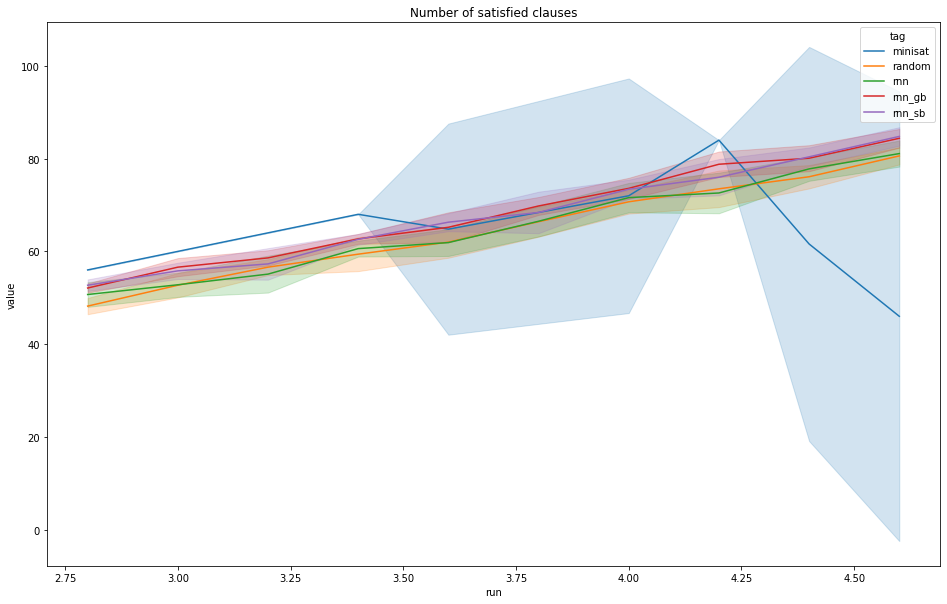

In [7]:
plt.figure(figsize=(16, 10))
sns.lineplot(x='run', y='value', hue='tag', ci='sd', data=df, markers=True, estimator='mean').set_title("Number of satisfied clauses")

In [8]:
df['ratio'] = df['value'] * 1/(df['run'].astype(float) * 20)

Text(0.5, 1.0, 'Ratio of satisfied clauses')

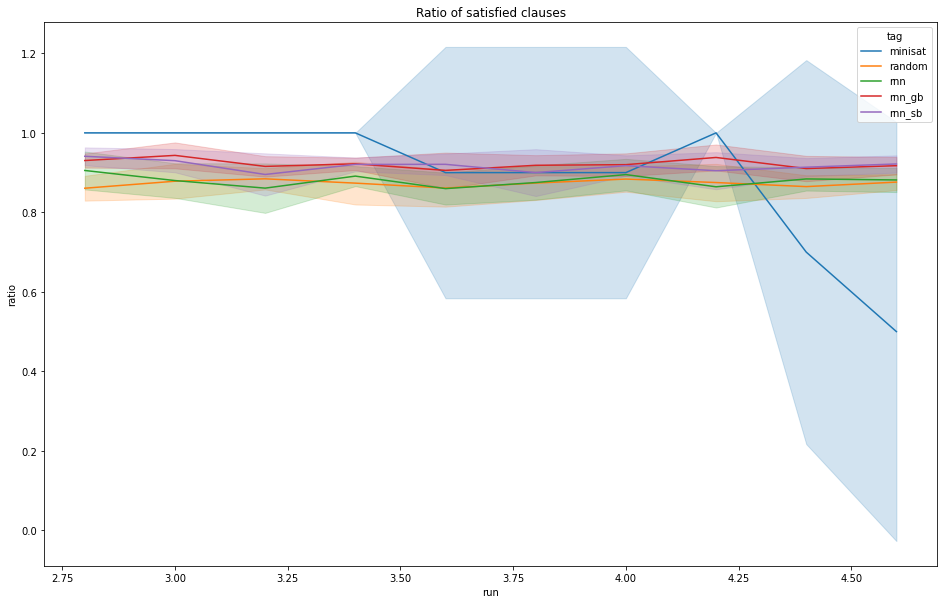

In [9]:
plt.figure(figsize=(16, 10))
sns.lineplot(x='run', y='ratio', hue='tag', ci='sd', data=df, estimator='mean').set_title("Ratio of satisfied clauses")